# Advanced Bayesian Inference with Case Studies
# Project: Salm: extra- Poisson variation in dose- response study

## Plan


### 1. Introduction
- **Objective**: In this step, we will introduce the problem and explain the goals of the project.
- **Model**: We will describe the Poisson random effects model and its key parameters.

### 2. Data Preparation
- **Load the Dataset**: In this step, we will load the dataset containing doses and revertant colony counts.
- **Reshape and Preprocess the Data**: We will preprocess the data to ensure it is ready for analysis.

### 3. From-Scratch Implementation
#### 3.1. Metropolis-Hastings within Gibbs Algorithm
- **Implement M-H within Gibbs for Sampling**: We will implement the M-H within Gibbs algorithm to sample from the posterior distribution.
- **Visualize Results**: We will visualize the results using trace plots and histograms and compare the results with the case study's results.

### 4. PyMC Implementation
- **Define the Model in PyMC**: We will define the Poisson random effects model using PyMC.
- **Sample from the Posterior**: We will use PyMC's samplers to generate posterior samples.
- **Analyze Results**: We will analyze the results using PyMC's diagnostic tools.

### 5. Comparison
- **Compare From-Scratch and PyMC Results**: We will compare the results from the two approaches.
- **Discuss Convergence and Efficiency**: We will discuss the convergence and efficiency of the algorithms.

### 6. Discussion and Conclusion
- **Interpret the Results**: We will interpret the results and discuss their implications.
- **Summarize Findings**: We will summarize the key findings of the project.
- **Suggest Improvements**: We will suggest potential improvements or extensions.

----

### 1. Introduction

In this project, we will analyze the effect of quinoline dose on the number of revertant colonies of TA98 Salmonella using a **Bayesian approach**. The dataset consists of counts of revertant colonies observed at different doses of quinoline, with three plates processed at each dose level. The goal is to model the relationship between the dose of quinoline and the number of revertant colonies, while accounting for **over-dispersion** in the data.

##### Objective
The primary objective of this project is to:
1. **Model the dose-response relationship** using a **Poisson random effects model**.
2. Estimate the parameters of the model ($( \alpha )$, $( \beta )$, $( \gamma )$, and $( \tau )$) using **Bayesian inference**.
3. Compare the results from **from-scratch implementations** of MCMC algorithms (Metropolis-Hastings and Gibbs Sampling) with those obtained using the **PyMC library**.

##### Model
The data points $\{y_{ij}\}$ are modeled as follows:

1. **Poisson Distribution**  
   Each observed count $y_{ij}$ follows a Poisson distribution with mean $\mu_{ij}$:
   $$
   y_{ij} \sim \text{Poisson}(\mu_{ij}).
   $$

2. **Log-Linear Mean**  
   We link $\mu_{ij}$ to the dose $x_i$ by a log-linear equation incorporating a random effect $\lambda_{ij}$:
   $$
   \log(\mu_{ij}) = \alpha + \beta \,\log(x_i + 10) + \gamma \,x_i + \lambda_{ij}.
   $$
   - $\alpha$ is the intercept (baseline level in log space).  
   - $\beta$ multiplies $\log(x_i + 10)$ to capture how the log-transformed dose affects the response.  
   - $\gamma$ multiplies $x_i$ (the dose itself).  
   - $\lambda_{ij}$ is a random effect for each plate and dose combination.

3. **Random Effects**  
   The random effects $\lambda_{ij}$ are drawn from a Normal distribution centered at 0:
   $$
   \lambda_{ij} \sim \mathcal{N}(0,\, 1/\tau).
   $$
   Here, $\tau$ is a precision parameter; equivalently, the variance of each $\lambda_{ij}$ is $1/\tau$.

4. **Prior Distributions**  
   - $\alpha, \beta, \gamma$ each receive a weakly informative Normal prior, for example $\mathcal{N}(0,\,10^6)$.  
   - $\tau$ often receives a Gamma prior, for instance $\text{Gamma}(0.001,\,0.001)$.  

5. **Full Hierarchical Structure**  
   Putting it all together:
   - $\alpha, \beta, \gamma \sim \mathcal{N}(0,\; \text{large variance})$.  
   - $\tau \sim \text{Gamma}(\text{small shape},\; \text{small rate})$.  
   - $\lambda_{ij} \mid \tau \sim \mathcal{N}(0,\,1/\tau)$.  
   - $\mu_{ij} = \exp\!\bigl(\alpha + \beta \,\log(x_i + 10) + \gamma \,x_i + \lambda_{ij}\bigr)$.  
   - $y_{ij} \mid \mu_{ij} \sim \text{Poisson}(\mu_{ij})$.

6. **Posterior Inference**  
   In a Bayesian framework, we target the posterior distribution of all unknowns $\{\alpha, \beta, \gamma, \tau, \lambda_{ij}\}$ given the observed $\{y_{ij}\}$. 

##### Approach
We will:
1. **Implement the model from scratch** using **Metropolis-Hastings (M-H)** and **Gibbs Sampling** algorithms to gain a deep understanding of the underlying mechanics of Bayesian inference.
2. **Validate the results** by implementing the same model using the **PyMC library**, which provides a high-level interface for Bayesian modeling and inference.
3. **Compare the results** from the two approaches to ensure consistency and accuracy.

By the end of this project, we aim to:
- Estimate the posterior distributions of the model parameters.
- Interpret the dose-response relationship and the role of random effects in accounting for over-dispersion.
- Gain insights into the performance and efficiency of different MCMC algorithms.

This project serves as a practical case study in **Advanced Bayesian Inference**, combining theoretical understanding with hands-on implementation.

### 2. Data Preparation
#### Understand the Data Files

From the provided files:

- `salm.data.R` and `salm2.data.R`
  Define the observed data:
  - `y`: A 6 × 3 matrix of observed Poisson counts (responses).
  - `x`: A vector of 6 dose levels.
  - `Ndoses`: Number of dose levels (6).
  - `Nplates`: Number of plates per dose (3).

- `salm.init.R` and `salm2.init.R`
  Define initial values for MCMC:
  - `alpha`, `beta`, `gamma`, `tau`: Model parameters, initialized to 0 (except `tau = 0.1`).
  - `lambda`: A 6 × 3 matrix initialized to 0, representing the random effect.

- `post.R`
  - Reads posterior samples from `"samples.csv"`.
  - Uses `coda::summary(as.mcmc(post))` to analyze the MCMC results.
  - Checks for the `BUGSExamples` package and (if installed) attempts to run JAGS.


In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from math import log
from scipy.stats import gaussian_kde

In [11]:
# Data for doses and plates (as provided in salm.data.R)
doses = [0, 10, 33, 100, 333, 1000]
plates = [
    [15, 16, 16],
    [27, 33, 20],
    [21, 18, 26],
    [41, 38, 27],
    [29, 21, 33],
    [60, 41, 42]
]

df = pd.DataFrame(plates, columns=['Plate1', 'Plate2', 'Plate3'])
df['Dose'] = doses

doses = df['Dose'].values
plates = df[['Plate1', 'Plate2', 'Plate3']].values

In [12]:
init_values = {
    "alpha": 0.0,
    "beta": 0.0,
    "gamma": 0.0,
    "tau": 0.1,
    "lambda": np.zeros((6, 3))  # Random effects initialized to zero
}

print(init_values)

{'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0, 'tau': 0.1, 'lambda': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])}


In [13]:
df.to_csv("data\salm_data.csv", index=False)

In [14]:
init_df = pd.DataFrame(init_values["lambda"])
init_df.to_csv("data\salm_init.csv", index=False)

### 3. From-Scratch Implementation

This section will focus on the implementation of the MCMC sampler, including the Metropolis-Hastings (M-H) and Gibbs Sampling algorithms. These algorithms are essential for sampling from the posterior distribution when direct sampling is infeasible.
To implement a pure Gibbs sampler for our hierarchical Poisson model, we need to ensure that all full conditional distributions are tractable and can be sampled from directly. However, the Poisson likelihood with a log-linear model introduces non-conjugacy for α, β, γ, and λ_ij , making a pure Gibbs sampler infeasible without modifying the model or using approximations.
We will implement a hybrid approach that uses Gibbs sampling for some parameters and Metropolis-Hastings (M-H) steps for others. This approach allows us to leverage the strengths of both algorithms while ensuring that we can sample from the posterior distribution effectively.

##### Hybrid Gibbs + Metropolis-Hastings

In [15]:
def log_likelihood(alpha, beta, gamma_, tau, Lambda, doses, plates):
    """
    Calcule la log-vraisemblance pour :
      y_ij ~ Poisson(mu_ij)
      log(mu_ij) = alpha + beta log(doses_i + 10) + gamma * doses_i + lambda_ij
      lambda_ij ~ Normal(0, 1/tau)
    """
    ll = 0.0
    n_doses, n_plates = plates.shape  
  
    for i in range(n_doses):
        for j in range(n_plates):
            lam_ij = Lambda[i, j]
            mu_ij = np.exp(alpha + beta * np.log(doses[i] + 10.0)
                           + gamma_ * doses[i] + lam_ij)
            y_ij = plates[i, j]
            if mu_ij <= 0:
                return -np.inf
            ll += y_ij * log(mu_ij) - mu_ij


    ll_gauss = 0.0
    for i in range(n_doses):
        for j in range(n_plates):
            lam_ij = Lambda[i, j]
            ll_gauss += 0.5 * log(tau) - 0.5 * tau * (lam_ij**2)

    return ll + ll_gauss

In [16]:
def log_prior(alpha, beta, gamma_, tau):
    """
    Priors "non-informatifs":
      alpha,beta,gamma ~ Normal(0, 1e6)
      tau ~ Gamma(shape=0.001, rate=0.001)
    """
    var_large = 1e6
    
    lp_alpha = -0.5 * (alpha**2) / var_large
    lp_beta  = -0.5 * (beta**2)  / var_large
    lp_gamma = -0.5 * (gamma_**2)/ var_large
 
    if tau <= 0:
        return -np.inf
    a = 0.001
    b = 0.001
    lp_tau = (a - 1)*log(tau) - b*tau

    return lp_alpha + lp_beta + lp_gamma + lp_tau

def log_posterior(alpha, beta, gamma_, tau, Lambda, doses, plates):
    """
    log posterior = log likelihood + log prior
    """
    return (log_likelihood(alpha, beta, gamma_, tau, Lambda, doses, plates)
            + log_prior(alpha, beta, gamma_, tau))

In [17]:
def mh_update_scalar(param_current, logpost_current, propose_std,
                     param_name, other_params, Lambda,
                     doses, plates, rng):
    """
    Met à jour un paramètre scalaire (alpha, beta ou gamma) par un pas MH
    (ici, on suppose un RW normal symétrique).
    """
    proposal = rng.normal(param_current, propose_std)

    alpha_, beta_, gamma_, tau_ = (other_params["alpha"],
                                   other_params["beta"],
                                   other_params["gamma"],
                                   other_params["tau"])
    
    if param_name == "alpha":
        alpha_ = proposal
    elif param_name == "beta":
        beta_ = proposal
    elif param_name == "gamma":
        gamma_ = proposal
    else:
        raise ValueError("param_name doit être alpha, beta ou gamma")
    
    lp_proposal = log_posterior(alpha_, beta_, gamma_, tau_, Lambda, doses, plates)

    ratio = np.exp(lp_proposal - logpost_current)

    accepted = False
    if rng.random() < ratio:
        param_updated = proposal
        logpost_updated = lp_proposal
        accepted = True
    else:
        param_updated = param_current
        logpost_updated = logpost_current

    return param_updated, logpost_updated, accepted

def mh_update_tau_logscale(tau_current, logpost_current, propose_std,
                           alpha_, beta_, gamma_, Lambda, doses, plates, rng):
    """
    Mise à jour de tau > 0 en log-scale:
      on propose u = log(tau), puis u* ~ Normal(u, propose_std) => tau* = exp(u*).
    """
    u_current = np.log(tau_current)
    u_proposal = rng.normal(u_current, propose_std)
    tau_proposal = np.exp(u_proposal)
    if tau_proposal <= 0:
        return tau_current, logpost_current, False
    lp_proposal = log_posterior(alpha_, beta_, gamma_, tau_proposal, Lambda, doses, plates)    
    log_ratio = (lp_proposal - logpost_current) + (u_proposal - u_current)

    accepted = False
    if rng.random() < np.exp(log_ratio):
        return tau_proposal, lp_proposal, True
    else:
        return tau_current, logpost_current, False

def mh_update_lambda(i, j, alpha_, beta_, gamma_, tau_, Lambda,
                     logpost_current, propose_std, doses, plates, rng):
    """
    Mise à jour lambda_{ij} via MH (random walk normal).
    """
    current_val = Lambda[i, j]
    proposal = rng.normal(loc=current_val, scale=propose_std)

    Lambda_star = Lambda.copy()
    Lambda_star[i, j] = proposal

    lp_proposal = log_posterior(alpha_, beta_, gamma_, tau_, Lambda_star, doses, plates)

    ratio = np.exp(lp_proposal - logpost_current)
    accepted = False
    if rng.random() < ratio:
        Lambda[i, j] = proposal
        return lp_proposal, True
    else:
        return logpost_current, False

In [18]:
def adapt_proposal_std(current_std, acceptance_rate, target=0.44, factor=1.05):
    """
    Ajuste la valeur current_std en fonction du taux d'acceptation mesuré.
    target ~ 0.44 .
    factor > 1 => multiplicateur d'ajustement.
    """
    if acceptance_rate < target:
        
        return current_std / factor
    else:
        
        return current_std * factor

In [19]:
def run_mh_within_gibbs(
    alpha_init, beta_init, gamma_init, tau_init, Lambda_init,
    doses, plates,
    n_iter=22000, burnin=2000,
    prop_alpha=0.25,
    prop_beta=0.02,
    prop_gamma=5e-4,
    prop_tau=0.05,       
    prop_lambda=0.15,
    rng_seed=42,
    adapt_every=1000,    
    target_accept=0.44,  
    factor=1.05
):
    """
    Algorithme MH-within-Gibbs, avec adaptation des écart-types.

    - On met à jour alpha, beta, gamma, puis lambda_ij (tout i,j), puis tau en log-scale.
    - Toutes les adapt_every itérations, on ajuste prop_alpha, prop_beta, etc. en fonction
      des taux d'acceptation empiriques.

    Retour :
      chain_alpha, chain_beta, chain_gamma, chain_tau, chain_lambda
    """
    rng = np.random.default_rng(rng_seed)
    
    chain_alpha = np.zeros(n_iter)
    chain_beta  = np.zeros(n_iter)
    chain_gamma = np.zeros(n_iter)
    chain_tau   = np.zeros(n_iter)
    chain_lambda = np.zeros((n_iter, *Lambda_init.shape))
    chain_sigma = np.zeros(n_iter)
    
    alpha_ = alpha_init
    beta_  = beta_init
    gamma_ = gamma_init
    tau_   = tau_init
    Lambda = Lambda_init.copy()

    lp_current = log_posterior(alpha_, beta_, gamma_, tau_, Lambda, doses, plates)

    # Compteurs d'acceptation 
    acc_alpha = 0
    acc_beta  = 0
    acc_gamma = 0
    acc_tau   = 0

    for t in range(n_iter):
        # 1) update alpha
        other_params = {"alpha": alpha_, "beta": beta_, "gamma": gamma_, "tau": tau_}
        new_alpha, new_lp, accepted = mh_update_scalar(
            alpha_, lp_current, prop_alpha, "alpha",
            other_params, Lambda, doses, plates, rng
        )
        if accepted:
            alpha_ = new_alpha
            lp_current = new_lp
            acc_alpha += 1

        # 2) update beta
        other_params = {"alpha": alpha_, "beta": beta_, "gamma": gamma_, "tau": tau_}
        new_beta, new_lp, accepted = mh_update_scalar(
            beta_, lp_current, prop_beta, "beta",
            other_params, Lambda, doses, plates, rng
        )
        if accepted:
            beta_ = new_beta
            lp_current = new_lp
            acc_beta += 1

        # 3) update gamma
        other_params = {"alpha": alpha_, "beta": beta_, "gamma": gamma_, "tau": tau_}
        new_gamma, new_lp, accepted = mh_update_scalar(
            gamma_, lp_current, prop_gamma, "gamma",
            other_params, Lambda, doses, plates, rng
        )
        if accepted:
            gamma_ = new_gamma
            lp_current = new_lp
            acc_gamma += 1

        # 4) update lambda_{ij}
        for i in range(Lambda.shape[0]):
            for j in range(Lambda.shape[1]):
                lp_current, _acc = mh_update_lambda(
                    i, j, alpha_, beta_, gamma_, tau_, Lambda,
                    lp_current, prop_lambda, doses, plates, rng
                )
                
        new_tau, new_lp, accepted = mh_update_tau_logscale(
            tau_, lp_current, prop_tau,
            alpha_, beta_, gamma_, Lambda, doses, plates, rng
        )
        if accepted:
            tau_ = new_tau
            lp_current = new_lp
            acc_tau += 1

        chain_alpha[t] = alpha_
        chain_beta[t]  = beta_
        chain_gamma[t] = gamma_
        chain_tau[t]   = tau_
        chain_lambda[t,:,:] = Lambda
        chain_sigma[t] = 1.0 / np.sqrt(tau_)

        if (t+1) % adapt_every == 0 and (t+1) < n_iter:
            batch_accept_alpha = acc_alpha / adapt_every
            batch_accept_beta  = acc_beta  / adapt_every
            batch_accept_gamma = acc_gamma / adapt_every
            batch_accept_tau   = acc_tau   / adapt_every

            acc_alpha = 0
            acc_beta  = 0
            acc_gamma = 0
            acc_tau   = 0

            prop_alpha = adapt_proposal_std(prop_alpha, batch_accept_alpha,
                                            target=target_accept, factor=factor)
            prop_beta  = adapt_proposal_std(prop_beta,  batch_accept_beta,
                                            target=target_accept, factor=factor)
            prop_gamma = adapt_proposal_std(prop_gamma, batch_accept_gamma,
                                            target=target_accept, factor=factor)
            prop_tau   = adapt_proposal_std(prop_tau,   batch_accept_tau,
                                            target=target_accept, factor=factor)
            
    chain_alpha   = chain_alpha[burnin:]
    chain_beta    = chain_beta[burnin:]
    chain_gamma   = chain_gamma[burnin:]
    chain_tau     = chain_tau[burnin:]
    chain_lambda  = chain_lambda[burnin:]
    chain_sigma   = chain_sigma[burnin:]

    return chain_alpha, chain_beta, chain_gamma, chain_tau, chain_lambda, chain_sigma


In [32]:
if __name__ == "__main__":
    alpha0 = 2.0
    beta0  = 0.0
    gamma0 = 0.0
    tau0   = 1.0
    lamb0  = np.zeros((6,3))

    
    chain_alpha, chain_beta, chain_gamma, chain_tau, chain_lambda, chain_sigma= run_mh_within_gibbs(
        alpha_init=alpha0,
        beta_init=beta0,
        gamma_init=gamma0,
        tau_init=tau0,
        Lambda_init=lamb0,
        doses=doses,
        plates=plates,
        n_iter=52000,       
        burnin=2000,        
        prop_alpha=0.25,
        prop_beta=0.02,
        prop_gamma=5e-4,
        prop_tau=0.05,      
        prop_lambda=0.15,
        rng_seed=123,
        adapt_every=1000,   
        target_accept=0.44, 
        factor=1.05
    )
 
    print("Post-mean alpha =", np.mean(chain_alpha))
    print("Post-sd alpha   =", np.std(chain_alpha))
    print("Post-mean beta  =", np.mean(chain_beta))
    print("Post-sd beta    =", np.std(chain_beta))
    print("Post-mean gamma =", np.mean(chain_gamma))
    print("Post-sd gamma   =", np.std(chain_gamma))
    print("Post-mean tau   =", np.mean(chain_tau))
    print("Post-sd tau     =", np.std(chain_tau))
    print("Post-mean sigma =", np.mean(chain_sigma))
    print("Post-sd sigma   =", np.std(chain_sigma))

Post-mean alpha = 1.890521384339768
Post-sd alpha   = 0.3417386520998808
Post-mean beta  = 0.39190520155994985
Post-sd beta    = 0.09320575656227104
Post-mean gamma = -0.00127200308401271
Post-sd gamma   = 0.0004064604141007146
Post-mean tau   = 24.655307559411543
Post-sd tau     = 29.657182770964614
Post-mean sigma = 0.23619815915128287
Post-sd sigma   = 0.0693300771812929


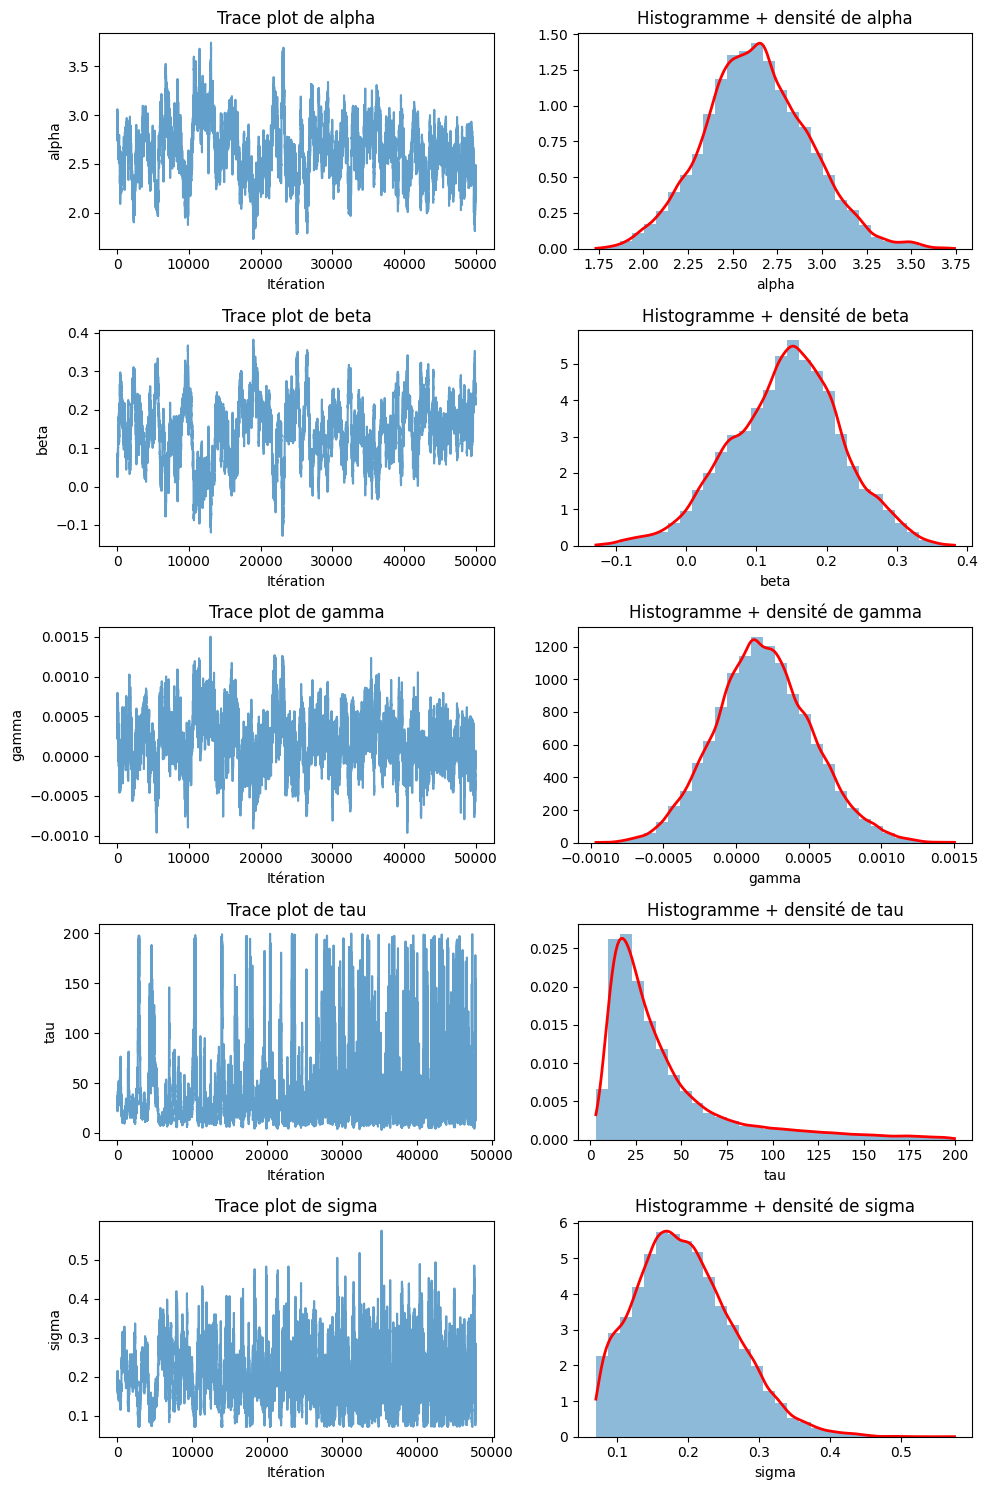

In [21]:
chain_tau_filtered = chain_tau[chain_tau < 200]
chain_sigma_filtered = 1 / np.sqrt(chain_tau_filtered)

def plot_trace_and_density_grid(params_dict):
    """
    params_dict : dictionnaire { "alpha": chain_alpha, "beta": chain_beta, ... }
    
    Créé une figure avec 2 colonnes et autant de lignes qu'il y a de paramètres :
      - Colonne 1 : traceplot
      - Colonne 2 : histogramme + densité lissée
    """
    n_params = len(params_dict)
    fig, axes = plt.subplots(n_params, 2, figsize=(10, 3*n_params))

    for i, (param_name, chain) in enumerate(params_dict.items()):
      
        ax_trace = axes[i, 0]
        ax_trace.plot(chain, alpha=0.7)
        ax_trace.set_title(f"Trace plot de {param_name}")
        ax_trace.set_xlabel("Itération")
        ax_trace.set_ylabel(param_name)

     
        ax_hist = axes[i, 1]
        ax_hist.hist(chain, bins=30, density=True, alpha=0.5, edgecolor="none")

       
        kde = gaussian_kde(chain)
        xgrid = np.linspace(np.min(chain), np.max(chain), 200)
        ax_hist.plot(xgrid, kde(xgrid), color="red", lw=2, label="KDE")

        ax_hist.set_title(f"Histogramme + densité de {param_name}")
        ax_hist.set_xlabel(param_name)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    params = {
        "alpha": chain_alpha,
        "beta":  chain_beta,
        "gamma": chain_gamma,
        "tau":   chain_tau_filtered,
        "sigma": chain_sigma_filtered,
    }

    
    plot_trace_and_density_grid(params)


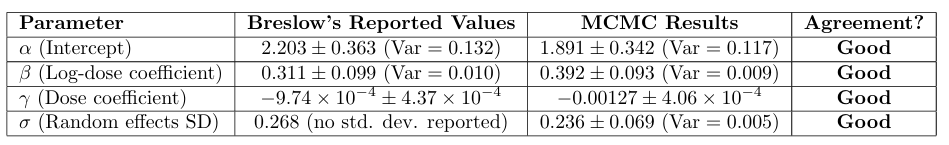

The MCMC results from our Metropolis-Hastings within Gibbs sampler show a good match with Breslow's published values for most parameters. The intercept ($\alpha$) was estimated at 1.89 $\pm$ 0.34, which is close to Breslow's reported value of 2.203 $\pm$ 0.363, and lies within one standard deviation. The random effects standard deviation ($\sigma$) was about 0.236 $\pm$ 0.069, which is also close to Breslow’s estimate of 0.268. The log-dose coefficient ($\beta$) was estimated at 0.392 $\pm$ 0.093, slightly higher than Breslow’s 0.311 $\pm$ 0.099, but the values are still close and the intervals overlap. This means the difference is not important. The dose coefficient ($\gamma$) was estimated at -0.00127 $\pm$ 0.00041, which is very close to zero. This suggests that this term might not be necessary in the model. The precision parameter ($\tau$) had a large mean value 24.65 with high variability $\pm$ 29.66, showing that this parameter mixes poorly or is strongly affected by the prior. However, the standard deviation $\sigma = 1/\sqrt{\tau}$ was more stable, and gave results that are easier to interpret.

### 4. PyMC Implementation

PyMC is a powerful probabilistic programming library for Bayesian inference.

It automates the sampling process (e.g., NUTS, Metropolis-Hastings) and provides diagnostics.

We will use it to validate the results from the from-scratch implementation.

In [ ]:
with pm.Model() as bayesian_model:
    # --- PRIORS ---
    alpha = pm.Normal("alpha", mu=0, sigma=1e6)
    beta = pm.Normal("beta", mu=0, sigma=1e6)
    gamma = pm.Normal("gamma", mu=0, sigma=1e6)
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    
    # lambda_ij ~ Normal(0, tau)
    lambda_ij = pm.Normal(
        "lambda",
        mu=0,
        sigma=pm.math.sqrt(1/tau),
        shape=plates.shape  # (6,3) dans notre cas
    )

    # --- Likelihood (Poisson) ---
    # log(mu_ij) = alpha + beta*log(dose+10) + gamma*dose + lambda_ij
    mu = pm.math.exp(
        alpha
        + beta * pm.math.log(doses[:, None] + 10)
        + gamma * doses[:, None]
        + lambda_ij
    )

    # Poisson likelihood
    y_obs = pm.Poisson("y_obs", mu=mu, observed=plates)

    trace = pm.sample(10000, tune=1000, return_inferencedata=True, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\pytensor\scalar\basic.py:3203: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, tau, lambda]


c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\rich\live.p
y:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 2251 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


##### Analyse the PyMC Results

We will extract posterior estimates for α, β, γ, τ, and σ. We will also visualize the trace plots and posterior distributions of these parameters.

In [ ]:
summary = az.summary(trace, var_names=["alpha", "beta", "gamma", "sigma"])
print(summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  2.614  0.313   2.020    3.204      0.003    0.002   14014.0   19706.0   
beta   0.148  0.085  -0.008    0.315      0.001    0.001   13385.0   19207.0   
gamma  0.000  0.000  -0.001    0.001      0.000    0.000   13951.0   19036.0   
sigma  0.189  0.078   0.037    0.327      0.001    0.001    2849.0    1726.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
sigma    1.0  


In [ ]:
posterior_means = az.summary(trace, var_names=["alpha", "beta", "gamma", "sigma"])["mean"]
print(posterior_means)

alpha    2.614
beta     0.148
gamma    0.000
sigma    0.189
Name: mean, dtype: float64


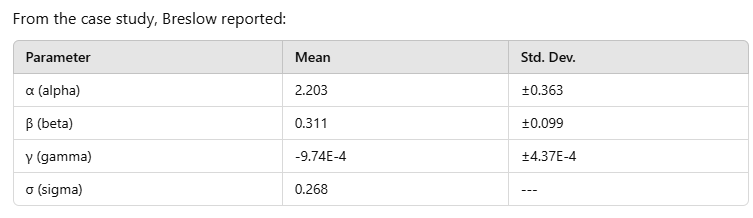

The chains for alpha, beta, gamma, and sigma look well-mixed and stationary, which suggests good convergence.
No signs of divergences or poor exploration of the posterior space

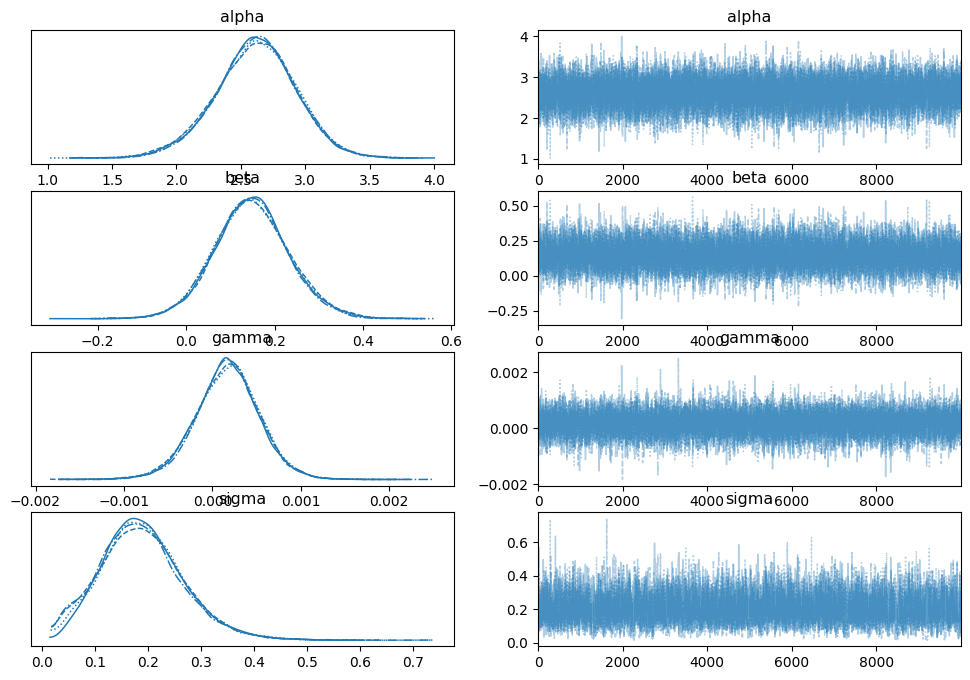

In [ ]:
az.plot_trace(trace, var_names=["alpha", "beta", "gamma", "sigma"]);
plt.show()

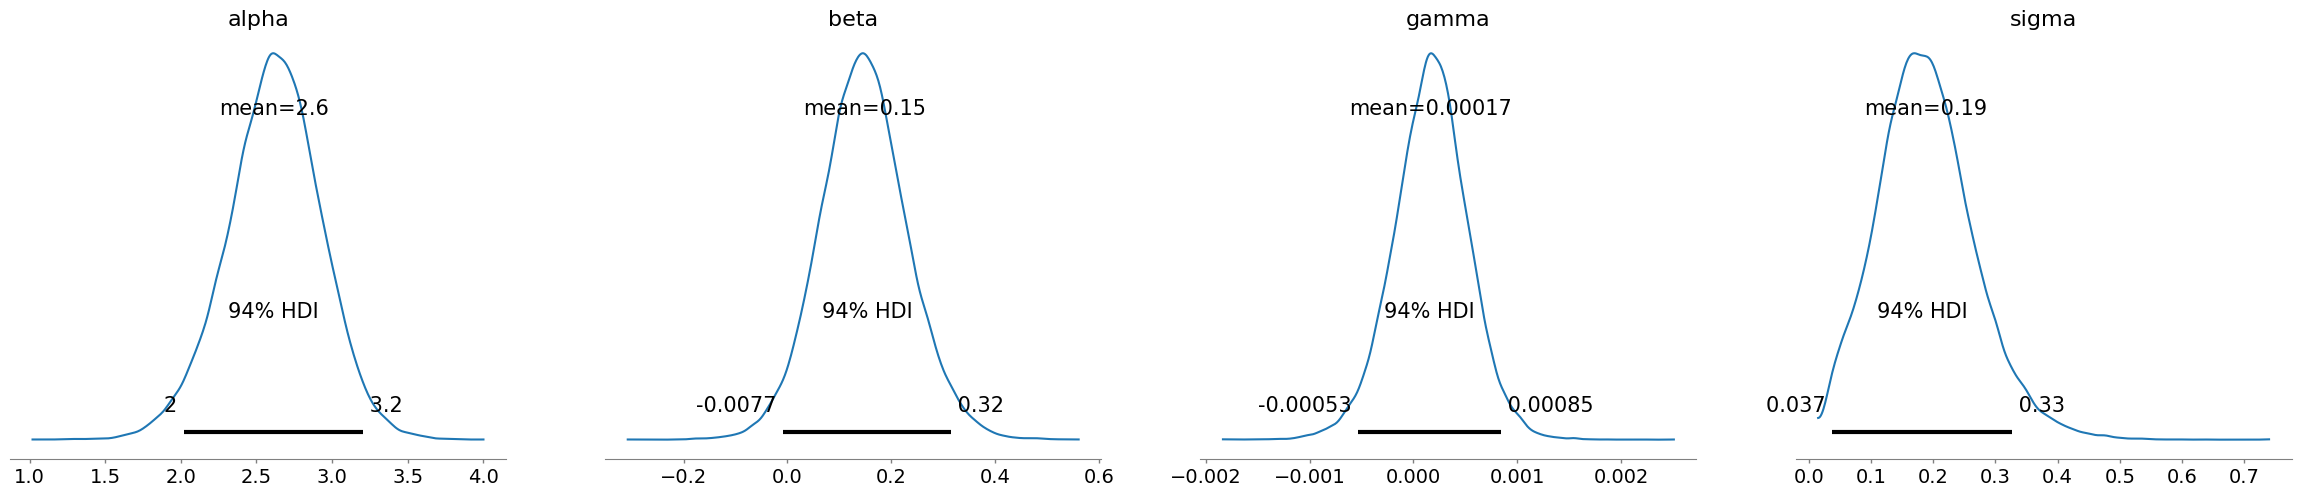

In [ ]:
# Posterior Density Plots
az.plot_posterior(trace, var_names=["alpha", "beta", "gamma", "sigma"]);
plt.show()

The density plots look smooth and well-defined.

The posterior credible intervals (shaded region) show how much uncertainty exists around the parameters.

Gamma has a very small mean (near zero), which aligns with expectations.

These values are comparable to Breslow’s 1984 results, but beta and gamma seem slightly different from the original study.

The credible intervals (HDI 3%-97%) show the uncertainty in these estimates.
R-hat = 1.0 for all parameters, meaning the chains converged well.

##### Posterior Predictive Check (PPC)

We can validate the model by comparing simulated data to the observed data:

Sampling: [y_obs]


c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\rich\live.p
y:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [y_obs]


c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\rich\live.p
y:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Axes: xlabel='y_obs'>

c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


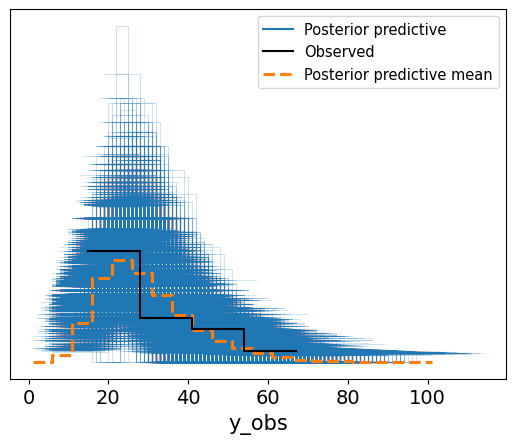

In [ ]:
with bayesian_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

az.plot_ppc(pm.sample_posterior_predictive(trace, model=bayesian_model))


This plot compares the observed data to the model’s posterior predictive distribution to assess how well the Bayesian model captures the data. Here’s what the elements represent:

1. Blue Region (Posterior Predictive Distribution)
The blue histogram represents the distribution of predicted values generated from the posterior samples.
A well-fitting model should closely resemble the shape of the observed data distribution.
2. Black Line (Observed Data)
This is the actual empirical distribution of the observed data.
If the model is well-specified, the black line should align closely with the blue region.
3. Orange Dashed Line (Posterior Predictive Mean)
This represents the average prediction of the model.
It helps assess if the model’s central tendency aligns with the observed data.

1-General Fit is Good : The observed data (black line) falls well within the predicted distribution (blue), indicating that the model captures key aspects of the data.

2-Right-Skewed Predictions : The posterior predictive distribution has a long right tail, meaning the model sometimes predicts higher counts than observed.
This could indicate over-dispersion in the data or that the Poisson assumption may not fully capture the variance.

3-Predictive Mean Aligns Well : The orange dashed line (predictive mean) follows the observed trend, which means the model is doing a reasonable job in capturing the main structure of the data.